# Compare CUSUM against Bayesian Changepoint Detection

This notebook is the solution to a problem that occurs with the Bayesian Changepoint Detection algorithm. This algorithm predicts right before or right after a true change point event rather than event itself. Reason for this is that I'm modeling changes as ratios so "spikes" in the time series cause the algorithm to have off by one errors. To circumvent this issue I'm switching to CUSUM algorithm to detect changes.

In [1]:
from IPython import display
from pathlib import Path
import re

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy

In [2]:
def plot_values(
    metric_df: pd.DataFrame,
    bayespoint_df: pd.DataFrame,
    cusumpoint_df: pd.DataFrame,
    tok: str = "the",
):
    metric_plot = (
        p9.ggplot(metric_df >> ply.query(f"tok=='{tok}'"))
        + p9.aes(x="year_pair", y="change_metric_ratio", group=0)
        + p9.geom_line()
        + p9.coord_flip()
        + p9.theme_seaborn("white")
        + p9.labs(
            x="Year Shift",
            y="Ratio",
            title=f"Frequency + Semantic Ratio for Token ('{tok}')",
        )
    )

    bayes_years_predicted = (
        bayespoint_df
        >> ply.query(f"tok == '{tok}'&changepoint_prob > 0.5")
        >> ply.pull("year_pair")
    )

    for year in bayes_years_predicted:
        metric_plot += p9.annotate(
            "point",
            x=year,
            y=(
                metric_df
                >> ply.query(f"tok=='{tok}'")
                >> ply.query(f"year_pair=='{year}'")
                >> ply.pull("change_metric_ratio")
            )[0],
            fill="purple",
            size=4,
        )

    cusum_years_predicted = (
        cusumpoint_df >> ply.query(f"tok == '{tok}'") >> ply.pull("changepoint_idx")
    )

    for year in cusum_years_predicted:
        if year in bayes_years_predicted:
            metric_plot += p9.annotate(
                "point",
                x=year,
                y=(
                    metric_df
                    >> ply.query(f"tok=='{tok}'")
                    >> ply.query(f"year_pair=='{year}'")
                    >> ply.pull("change_metric_ratio")
                )[0],
                fill="green",
                size=4,
            )
        else:
            metric_plot += p9.annotate(
                "point",
                x=year,
                y=(
                    metric_df
                    >> ply.query(f"tok=='{tok}'")
                    >> ply.query(f"year_pair=='{year}'")
                    >> ply.pull("change_metric_ratio")
                )[0],
                fill="red",
                size=4,
            )

    return metric_plot

## Load the data

In [3]:
change_metric_df = pd.read_csv("output/change_metric_abstracts.tsv", sep="\t")
change_metric_df >> ply.slice_rows(10)

,year_pair,tok,ratio_metric,frequency_ratio,change_metric_ratio
0,2000-2001,!,2.250108,1.003918,3.254026
1,2000-2001,drop,2.380378,0.988707,3.369085
2,2000-2001,cfu,1.886854,0.717084,2.603938
3,2000-2001,interaction,1.765145,0.851699,2.616845
4,2000-2001,m2,2.155668,1.055401,3.211069
5,2000-2001,various,1.917591,0.963969,2.881560
6,2000-2001,pearson,2.151891,1.003918,3.155809
7,2000-2001,hdl\-,1.795933,8.365982,10.161915
8,2000-2001,driving,1.916479,0.941173,2.857652
9,2000-2001,mrs,1.877145,0.772244,2.649389


In [4]:
bayes_point_df = pd.read_csv("output/bayesian_changepoint_data_abstracts.tsv", sep="\t")
bayes_point_df >> ply.slice_rows(10)

,tok,changepoint_prob,year_pair
0,!,0.004488,2001-2002
1,!,0.004065,2002-2003
2,!,0.002007,2003-2004
3,!,0.003899,2004-2005
4,!,0.182222,2005-2006
5,!,0.155388,2006-2007
6,!,0.113705,2007-2008
7,!,0.110266,2008-2009
8,!,0.064739,2009-2010
9,!,0.042559,2010-2011


In [13]:
cusum_point_df = pd.read_csv("output/cusum_changepoint_abstracts.tsv", sep="\t")
cusum_point_df >> ply.slice_rows(10)

,tok,changepoint_idx,start_idx,end_idx,value
0,/5-,2016-2017,2015-2016,2016-2017,11.948682
1,/5-,2017-2018,2016-2017,2017-2018,-11.968209
2,/disease,2017-2018,2016-2017,2017-2018,12.327052
3,/disease,2018-2019,2017-2018,2018-2019,-12.264762
4,/ftc,2011-2012,2010-2011,2011-2012,11.435107
5,/gr,2016-2017,2015-2016,2016-2017,11.514803
6,/gr,2017-2018,2016-2017,2017-2018,-11.652937
7,/hypocretin,2014-2015,2013-2014,2014-2015,-11.475328
8,008,2008-2009,2007-2008,2008-2009,-12.270979
9,009,2009-2010,2008-2009,2009-2010,-31.879759


# Selected Tokens to Visualize Changepoints

Let's take a look a the predictions from both methods. The CUSUM method is in red while the bayesian changepoint detection algorithm is in green. The purple dots are algorithm prediction agreements.

## Pandemic

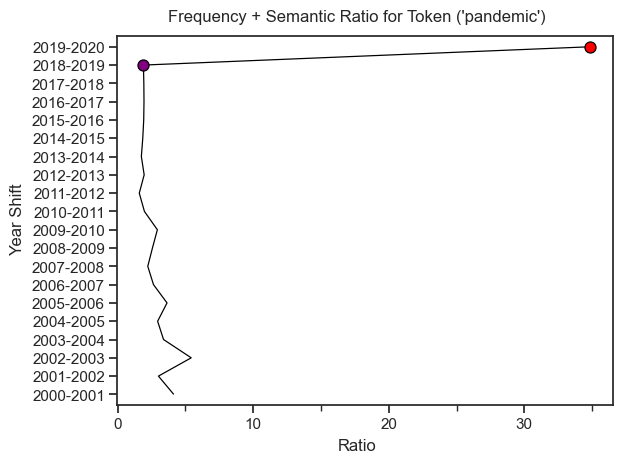

<ggplot: (-9223363287532963205)>

In [6]:
plot_values(change_metric_df, bayes_point_df, cusum_point_df, tok="pandemic")

## Abcc6

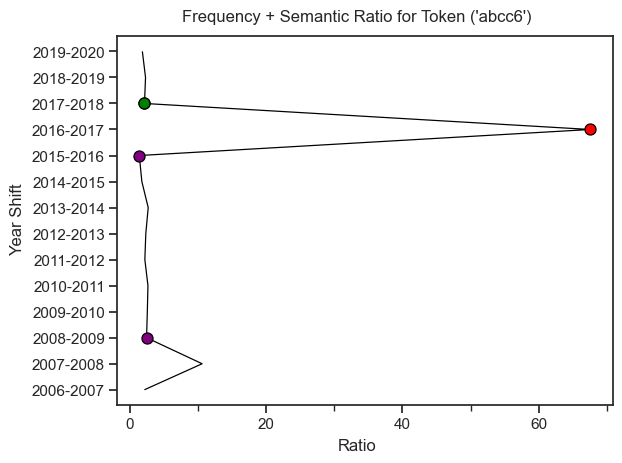

<ggplot: (-9223363287532940039)>

In [7]:
plot_values(change_metric_df, bayes_point_df, cusum_point_df, tok="abcc6")

## asthmatics

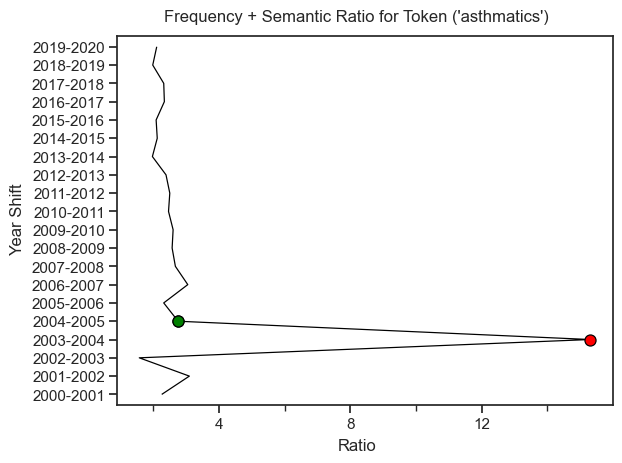

<ggplot: (8749348467085)>

In [8]:
plot_values(change_metric_df, bayes_point_df, cusum_point_df, tok="asthmatics")

## 2005

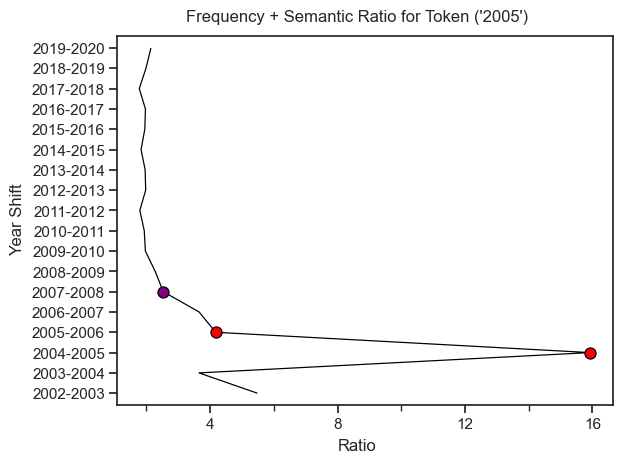

<ggplot: (-9223363287506383118)>

In [9]:
plot_values(change_metric_df, bayes_point_df, cusum_point_df, tok="2005")

# Take Home Points

1. Switch to CUSUM as it can accurately detect these spikes rather than a Bayesian method.
2. Raises the pitfall that ratios might not be the best way to model these changes; however, this is the only solution I can devise.